In [2]:
import sys
sys.path.append('..')
from sympy import sin, cos
from pytrajectory import TransitionProblem
from helicontrollers.util import Jp, Je, Jl, L1, L2, L3, L4
# from ModelConstants import d_p as mup, d_e as mue, d_l as mul
import numpy as np
from scipy.io import savemat
from matplotlib.pyplot import *
from gui.TrajectoryFrame import TypePolynomialFlatness, TypeOperatingPoint

In [101]:
# def f(x, u, uref, t, p):
#     x1, x2, x3, x4, x5, x6 = x
#     u1, u2 = u
# 
#     vs = (u1 + u2) / 2
#     vd = (u1 - u2) / 2
# 
#     ff = [
#         x4,
#         x5,
#         x6,
#         1 / Jp * (L1 * vd - mup * x4),
#         1 / Je * (L2 * cos(x2) + L3 * vs * cos(x1) - mue * x5),
#         1 / Jl * (L4 * vs * cos(x2) * sin(x1) - mul * x6)
#     ]
# 
#     return ff


In [104]:
# Versuch, PyTrajectory zu verwenden
ta = 0.0
tb = 3.0
xa = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
xb = [0.0, 30/180*np.pi, 30/180*np.pi, 0.0, 0.0, 0.0]

# cons = {"x0": [-80/180*np.pi, 80/180*np.pi],
#         "x1": [-70/180*np.pi, 70/180*np.pi],
#         "x2": [-120/180*np.pi, 120/180*np.pi]}
#cons = {"u1": [-0.1, 5.0],
#        "u2": [-0.1, 5.0]}
cons = {}

problem = TransitionProblem(f, a=ta, b=tb, xa=xa, xb=xb, constraints=cons)
sol = problem.solve()

INFO: 	 1 / 1 Iteration #1; spline parts_ 10
INFO: 	 1 / 1 par = []
INFO: 	 1 / 1 Iteration #2; spline parts_ 20
INFO: 	 1 / 1   --> reached desired accuracy: True
INFO: 	 1 / 1 par = []


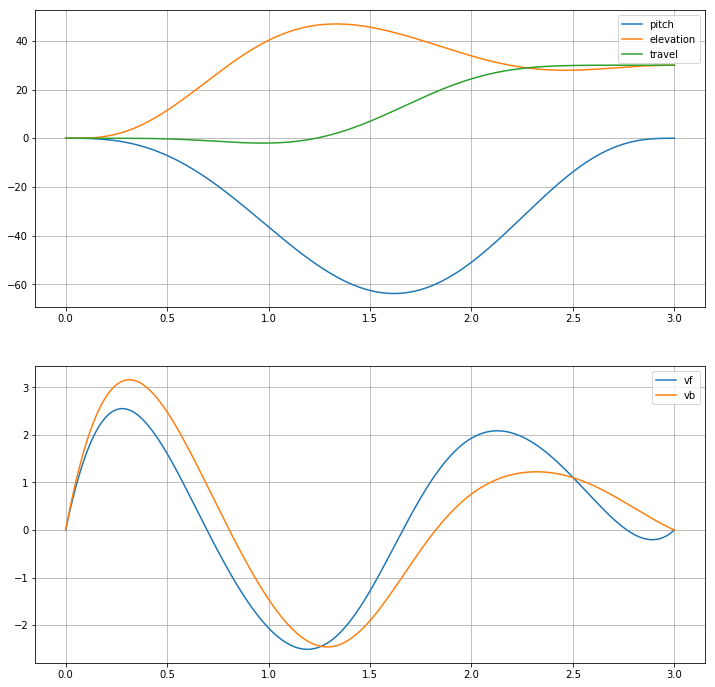

In [105]:
x_callable = sol[0]
u_callable = sol[1]

ts = np.linspace(ta, tb, 1500)
xs = np.array([x_callable(t) for t in ts])
us = np.array([u_callable(t) for t in ts])

figure(figsize=(12, 12))
subplot(211)
plot(ts, xs[:, 0]/np.pi*180, label="pitch")
plot(ts, xs[:, 1]/np.pi*180, label="elevation")
plot(ts, xs[:, 2]/np.pi*180, label="travel")
legend()
grid()

subplot(212)
plot(ts, us[:, 0], label="vf")
plot(ts, us[:, 1], label="vb")
legend()
grid()

In [99]:
savemat('matlab/move1.mat', {'t': ts, 'x': xs, 'u': us})

In [6]:
# Alternativ: flache Trajektorienplanung
traj_planner = TypeOperatingPoint()
for angle in range(0, 60, 5):
    traj_planner.elevation = angle
    traj_planner.travel = 0
    trajectory = traj_planner.generate()
    savemat(f"../matlab/static{angle}.mat", trajectory.to_dict())